# Comparison Avatar with Original : AIDS - R

In this notebook, we compare avatar with original data using the aids dataset. 
We use the avatarized dataset with the parameter k = 20. 

We perform 3 analyses : 
- 1 - projection comparison 
- 2 - Survival curve comparison 
- 3 - Protection level : metrics (local cloaking and hidden rate).

## Libraries importation

In [107]:
library(showtext)
library(reticulate)
library(tidyverse)
library(nloptr)
library(FactoMineR)
library(plot3D)
library(survival)
library(survminer)
library(mice)
library(reshape2)
library(corrplot)
library(VIM)

In [108]:
colors = read.csv("../../color.csv", stringsAsFactors = FALSE)
rownames(colors) = colors$type

The following cell import the necessary function in order to compute the metrics over the avatarization.

In [109]:
# import specific function to compute metrics
py_run_string("import sys")
py_run_string("sys.path.append('../../metrics')")
py_run_string("sys.path.append('../../dimension')")

py_run_string("from security_metrics_class import Security_metrics ")
py_run_string("from projection import Projection")
py_run_string("from record_to_avatar_distance import record_to_avatar_distance")
py_run_string("from local_cloaking import local_cloaking")

## Data loading

In [110]:
# setwd('../')
file_data <- "datasets/"
file_results <- "../../figure/"

In [122]:
data <- read.csv(paste0("../../datasets/AIDS/aids_original_data.csv"), sep = ";", 
    na.strings = c("NA", "", NA))
data <- data[, -1]

# Avatar data with k=20
avatar <- read.csv(paste0("../../datasets/AIDS/aids_avatarized_base_k20_nf5.csv"), 
    sep = ",", na.strings = c("NA", "", NA))

avatar$arms = as.factor(avatar$arms)

## Data and avatar imputation - Perform projection

In [123]:
# imput missing data to project the individuals in the multidimensionnal space
data_imp <- complete(mice(data, m = 1, maxit = 50, seed = 500, printFlag = FALSE), 
    1)
avatar_imp <- complete(mice(avatar, m = 1, maxit = 50, seed = 500, printFlag = FALSE), 
    1)

Warning message:
“Number of logged events: 51”Warning message:
“Number of logged events: 51”

In [124]:
data$cd496 <- data_imp$cd496
avatar$cd496 <- avatar_imp$cd496

In [125]:
data_tot <- rbind(data, avatar)
data_tot_num = data_tot
categorical = c("hemo", "homo", "drugs", "karnof", "oprior", "z30", "zprior", "race", 
    "gender", "str2", "strat", "symptom", "treat", "offtrt", "r", "cens", "arms")
data_tot[categorical] = lapply(data_tot[categorical], factor)

In [126]:
pca <- FAMD(data_tot, ncp = 5, graph = FALSE, ind.sup = (nrow(data_tot)/2 + 1):nrow(data_tot))
res_ind <- as.data.frame(pca$ind$coord)
res_ind_sup <- as.data.frame(pca$ind.sup$coord)

## Graph in 2D


We are here printing the mutlidimensionnal projection on the two first component of the FAMD (Factorial analysis of mixed data).

Individuals are colored by data sources : ORIGINAL or AVATARS.

In [127]:
res_ind_2D = res_ind[, 1:2]
res_ind_2D["type"] = "Originals"
res_ind_sup["type"] = "Avatars"
res_ind_2D = rbind(res_ind_2D, res_ind_sup[, c("Dim.1", "Dim.2", "type")])

set.seed(42)
rows <- sample(nrow(res_ind_2D))
res_ind_2D <- res_ind_2D[rows, ]

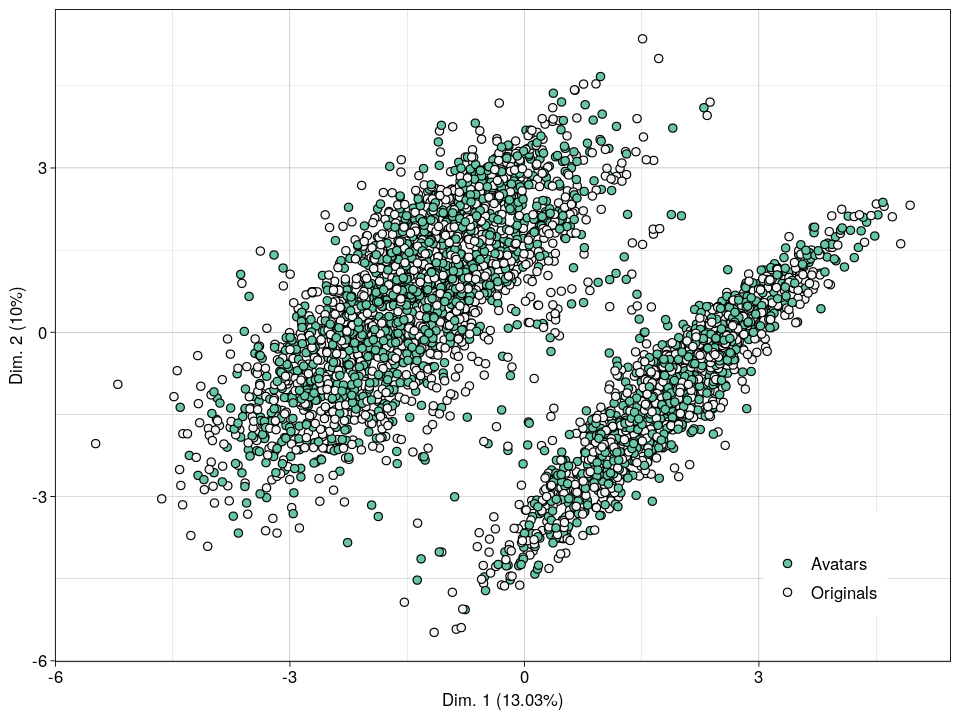

In [11]:
save = FALSE

options(repr.plot.width = 8, repr.plot.height = 6)
if (save) {
    tiff(paste0(file_results, "aids_pca2D.tiff"), res = 600, width = 14, height = 9, 
        units = "cm")
}


ggplot(res_ind_2D, aes(x = Dim.1, y = Dim.2, fill = type)) + geom_point(size = 2, 
    shape = 21, alpha = 1) + 
    aes(fill = factor(type)) + 
    scale_fill_manual(values = c(colors["avatar", "color"], 
                                 colors["original", "color"])) +
    xlab(paste0("Dim. 1 (", round(pca$eig[1, 2], 2), "%)")) +
    ylab(paste0("Dim. 2 (", round(pca$eig[2, 2], 2), "%)"))+ 
    labs(fill = "") +
    theme_linedraw() +
    theme(legend.position = c(0.86, 0.15), 
          legend.text = element_text(size = 10, color = "black",family = "Helvetica"), 
          axis.text = element_text(size = 10, color = "black", family = "Helvetica"), 
          axis.title = element_text(size = 10, color = "black", family = "Helvetica"), 
          legend.background = element_rect(fill="white", linetype="solid"))

if (save) {
    dev.off()
}

## Figure survival curve analysis 

We are comparing treatments efficacy arms 0 and arms 1 for original and avatar data.

### NEJM values

In [12]:
# paper results
df_paper_NEJM = data.frame(arms1 = c(0.5, 0.39, 0.63), arms2 = c(0.54, 0.43, 0.68), 
    arms3 = c(0.61, 0.49, 0.76), row.names = c("HR", "CI_low", "CI_high"))

### Original data analysis

In [13]:
data$arms = as.factor(data$arms)
summary_cox <- summary(coxph(Surv(time = days/7, event = cens) ~ arms, data = data))
res_ori = cbind(summary_cox$coefficients[, c("exp(coef)", "Pr(>|z|)")], summary_cox$conf.int[, 
    c("lower .95", "upper .95")])

In [14]:
val_arms0 <- "(Cox model reference)"
val_arms1 <- paste0("(HR [CI 95%]: ", format(round(as.vector(summary_cox$coefficients[1, 
    2]), 2), nsmall = 2), " [", format(round(as.vector(summary_cox$conf.int[1, 3]), 
    2), nsmall = 2), "-", format(round(as.vector(summary_cox$conf.int[1, 4]), 2), 
    nsmall = 2), "])")
val_arms2 <- paste0("(HR [CI 95%]: ", format(round(as.vector(summary_cox$coefficients[2, 
    2]), 2), nsmall = 2), " [", format(round(as.vector(summary_cox$conf.int[2, 3]), 
    2), nsmall = 2), "-", format(round(as.vector(summary_cox$conf.int[2, 4]), 2), 
    nsmall = 2), "])")
val_arms3 <- paste0("(HR [CI 95%]: ", format(round(as.vector(summary_cox$coefficients[3, 
    2]), 2), nsmall = 2), " [", format(round(as.vector(summary_cox$conf.int[3, 3]), 
    2), nsmall = 2), "-", format(round(as.vector(summary_cox$conf.int[3, 4]), 2), 
    nsmall = 2), "])")

### Avatar data analysis

In [113]:
summary_cox <- summary(coxph(Surv(time = days/7, event = cens) ~ (arms), data = avatar))

res_avat = cbind(summary_cox$coefficients[, c("exp(coef)", "Pr(>|z|)")], summary_cox$conf.int[, 
    c("lower .95", "upper .95")])

In [114]:
val_arms0_avat <- "(Cox model reference)"
val_arms1_avat <- paste0("(HR [CI 95%]: ", format(round(as.vector(summary_cox$coefficients[1, 
    2]), 2), nsmall = 2), " [", format(round(as.vector(summary_cox$conf.int[1, 3]), 
    2), nsmall = 2), "-", format(round(as.vector(summary_cox$conf.int[1, 4]), 2), 
    nsmall = 2), "])")
val_arms2_avat <- paste0("(HR [CI 95%]: ", format(round(as.vector(summary_cox$coefficients[2, 
    2]), 2), nsmall = 2), " [", format(round(as.vector(summary_cox$conf.int[2, 3]), 
    2), nsmall = 2), "-", format(round(as.vector(summary_cox$conf.int[2, 4]), 2), 
    nsmall = 2), "])")
val_arms3_avat <- paste0("(HR [CI 95%]: ", format(round(as.vector(summary_cox$coefficients[3, 
    2]), 2), nsmall = 2), " [", format(round(as.vector(summary_cox$conf.int[3, 3]), 
    2), nsmall = 2), "-", format(round(as.vector(summary_cox$conf.int[3, 4]), 2), 
    nsmall = 2), "])")

In [115]:
data_concat2 = data
data_concat2$type = "Original"
avatar$type = "Avatar"
data_concat2 = rbind(data_concat2, avatar)
data_concat2$type = as.factor(data_concat2$type)


data_concat2$type = relevel(data_concat2$type, "Original")
data_concat3 = data_concat2[data_concat2$arms %in% c(0, 1), ]

# fit the survival curve
surv = survfit(Surv(time = days/7, event = cens) ~ factor(arms) + (type), data = data_concat3)


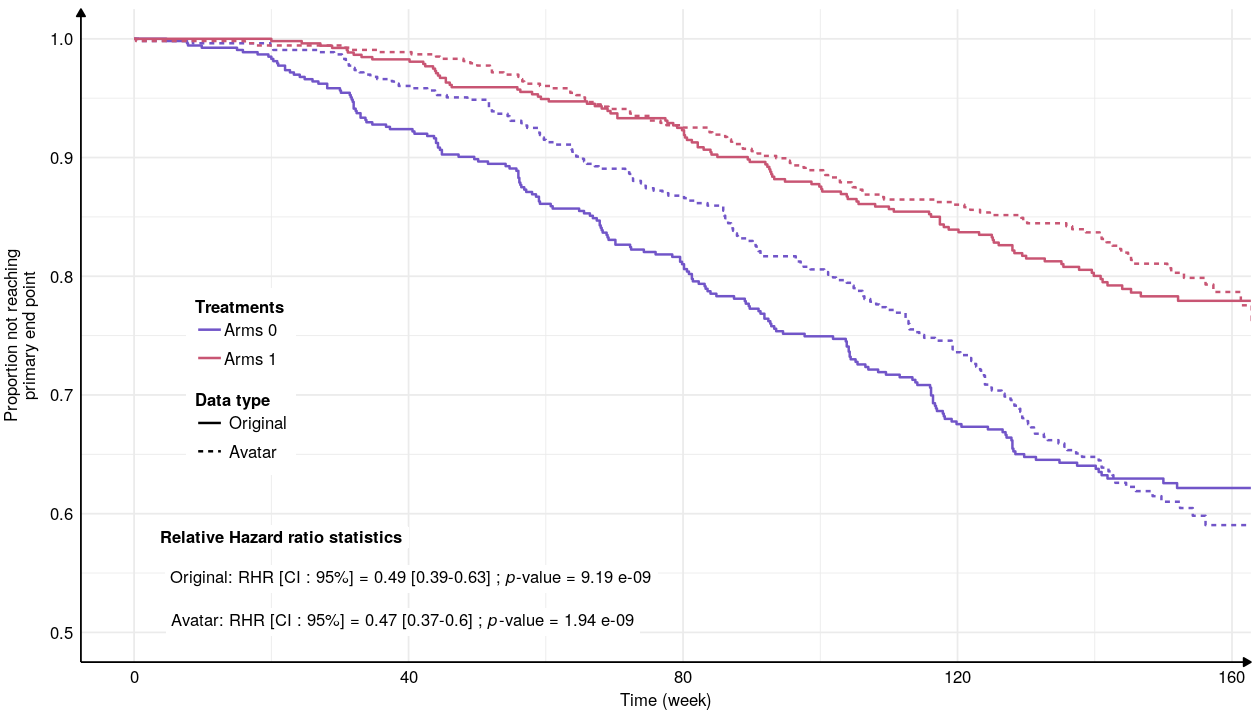

In [21]:
save = FALSE

options(repr.plot.width = 10.5, repr.plot.height = 6)
if (save) {
    tiff(paste0(file_results, "aids_avatar_survival_.tiff"), width = 16, height = 10, 
        units = "cm", res = 300)
}
par(mfrow = c(1, 1))


color = c("royalblue3", "seagreen", "darkorange3", "red3")
color2 = c("#55c8aa", "#95aa5b", "#c37e47", "#c85573")
color3 = c("#7155c8", "#c85573")


# create the survival curve 
ggsurv = ggsurvplot(surv, data = data_concat3, conf.int = FALSE, 
                    risk.table = FALSE, 
                    legend.title = "Treatments", legend = c(0.2, 0.3), 
                    censor.cex = 100, linetype = c("type"), 
                    size = 0.7, xlim = c(0, 155), ylim = c(0.5, 1), break.x.by = 40, 
                    ggtheme = theme_minimal(), 
                    xlab = "Time (week)", 
                    ylab = "Proportion not reaching\nprimary end point",
                    censor.shape = "", 
                    legend.labs = c("Arms 0", "Arms 0", "Arms 1", "Arms 1"), 
                    palette = color3)

# Custom the plot 
ggsurv$plot <- ggsurv$plot + 
    scale_linetype_discrete(name = c("Data type"), 
                            labels = c(" Original", 
                                       " Avatar"))+
    geom_label(aes( x = 6, y = 0.58, label = "Relative Hazard ratio statistics"), label.size = NA,
             hjust =0.08, size = 3.5, fontface =2, family = "Helvetica")+
    geom_label(aes( x = 10.2, y = 0.545, label = "'Original: RHR [CI : 95%] = 0.49 [0.39-0.63] ; '*  italic(p) *'-value = 9.19 e-09'"), 
             label.size = NA , hjust =0.08, size = 3.5, family = "Helvetica",  parse = T)+

    geom_label(aes( x = 10.2, y = 0.509, label = paste("'Avatar: RHR [CI : 95%] = 0.47 [0.37-0.6] ; '*  italic(p) * '-value = 1.94 e-09'")), 
             label.size = NA, hjust =0.08, size = 3.5, family = "Helvetica", parse = T)+
    theme_minimal() + 
    theme(legend.key.size = unit(0.6, "cm"),
          legend.position = c(0.137, 0.43), 
          legend.background = element_rect(fill="white", size=0.5, linetype="blank"),
          legend.text = element_text(size = 10,  color = "black", family = "Helvetica"),
          axis.text = element_text(size = 10, color = "black", family = "Helvetica"), 
          axis.title = element_text(size = 10, color = "black", family = "Helvetica"),
          axis.title.y = element_text(vjust = 2), 
          legend.title = element_text(size = 10, face = "bold", family = "Helvetica"), 
          legend.spacing.x = unit(ifelse(save, 0.3, 0), "cm"),
          legend.spacing.y = unit(ifelse(save, 0, 0), "cm"),
          axis.line = element_line(colour = "black", size = 0.5, linetype = "solid", 
                                   arrow = arrow(type = "closed", length = unit(5, "pt"))))


ggsurv


if (save) {
    dev.off()
}

### Supplemental graph

As a supplemental graph we present the survival curve for all treatments.

Warning message:
“Removed 1 row(s) containing missing values (geom_path).”Warning message:
“Removed 1 row(s) containing missing values (geom_path).”

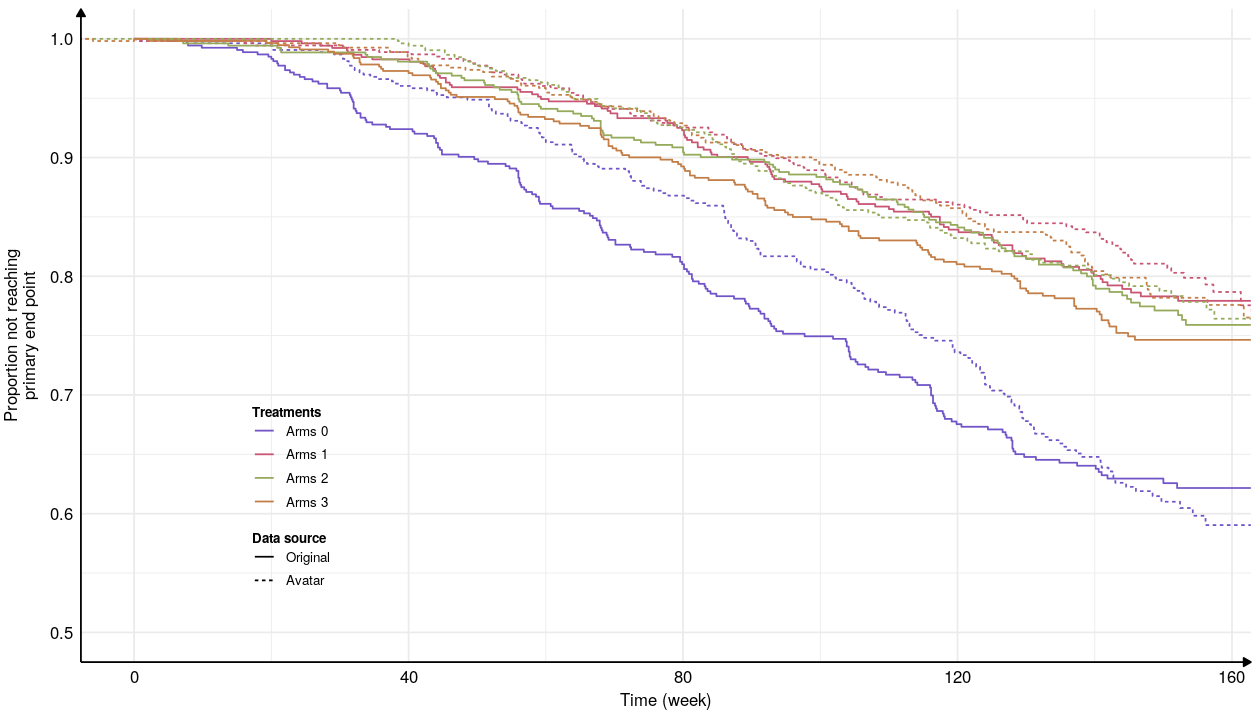

In [116]:
options(repr.plot.width = 10.5, repr.plot.height = 6)
if (save) {
    tiff(paste0(file_results, "aids_avatar_survival_supplemental.tiff"), width = 16, 
        height = 10, units = "cm", res = 300)
}
par(mfrow = c(1, 1))


color = c("royalblue3", "seagreen", "darkorange3", "red3")
color2 = c("#7155c8", "#c85573", "#95aa5b", "#c37e47")
color3 = c("#7155c8", "#c85573")


surv = survfit(Surv(time = days/7, event = cens) ~ factor(arms) + (type), data = data_concat2)

ggsurv = ggsurvplot(surv, data = data_concat2, 
                    conf.int = FALSE, risk.table = FALSE, 
                    legend.title = "Treatments", legend = c(0.2, 0.3), 
                    censor.cex = 100, linetype = c("type"), size = 0.5, xlim = c(0, 155), ylim = c(0.5, 1),
                    break.x.by = 40, ggtheme = theme_minimal(), xlab = "Time (week)", 
                    ylab = "Proportion not reaching\nprimary end point", 
                    censor.shape = "", 
                    legend.labs = c("Arms 0", "Arms 0", "Arms 1", "Arms 1", "Arms 2", 
                                    "Arms 2", "Arms 3", "Arms 3"), palette = color2)


ggsurv$plot <- ggsurv$plot + 
    theme_minimal() + 
    theme(legend.key.size = unit(0.5, "cm"), 
          legend.position = c(0.18, 0.25), 
          legend.text = element_text(size = 8, color = "black", family = "Helvetica"), 
          axis.text = element_text(size = 10, color = "black",  family = "Helvetica"), 
          axis.title = element_text(size = 10, color = "black", family = "Helvetica"), 
          axis.title.y = element_text(vjust = 2), 
          legend.title = element_text(size = 8, face = "bold", family = "Helvetica"), 
          legend.spacing.x = unit(ifelse(save, 1,  0.2), "cm"), 
          legend.spacing.y = unit(ifelse(save, 0, 0), "cm"), 
          axis.line = element_line(colour = "black", size = 0.5, linetype = "solid", 
                                   arrow = arrow(type = "closed", length = unit(5, "pt")))) + 
    scale_linetype_discrete(name = "Data source")


ggsurv


if (save) {
    dev.off()
}

### Supplemental : Relative hazard ratio comparison 

Relative hazard ratio are computed : this table presente reltives hazard ratio with arms 0 as reference. P-value and 95% confidence intervals are display.

In [117]:
rownames(res_ori) = c("arms1_original", "arms2_original", "arms3_original")
rownames(res_avat) = c("arms1_avatar", "arms2_avatar", "arms3_avatar")

res_concat = rbind(res_ori, res_avat)
res <- res_concat[order(rownames(res_concat)), ]
res[, "exp(coef)"] = round(res[, "exp(coef)"], 2)
res[, "lower .95"] = round(res[, "lower .95"], 2)
res[, "upper .95"] = round(res[, "upper .95"], 2)

colnames(res)[colnames(res) == "exp(coef)"] <- "Hazard Ratio"

res[, "Pr(>|z|)"][res[, "Pr(>|z|)"] < 0.001] <- "<0.001"
rownames(res) = c("Avatar arms1", "Original arms1", "Avatar arms2", "Original arms2", 
    "Avatar arms3", "Original arms3")

res_concat

,exp(coef),Pr(>|z|),lower .95,upper .95
arms1_original,0.4919521,9.193905e-09,0.3862056,0.6266529
arms2_original,0.5248619,1.069305e-07,0.4138086,0.6657183
arms3_original,0.5857967,3.679307e-06,0.4670923,0.7346679
arms1_avatar,0.4712010,1.936641e-09,0.3685611,0.6024249
arms2_avatar,0.5122958,6.429033e-08,0.4019899,0.6528697
arms3_avatar,0.4891743,9.576767e-09,0.3831712,0.6245027


In [119]:
res = as.data.frame(res)
cols = c('lower .95', 'upper .95')

res["95% Confidence Interval"] = apply( res[ , cols ] , 1 , paste , collapse = "-" )
res <- res[ , !( names( res ) %in% cols ) ]
res = res[,c("Hazard Ratio", "95% Confidence Interval", "Pr(>|z|)" )]
res

,Hazard Ratio,95% Confidence Interval,Pr(>|z|)
Avatar arms1,0.47,0.37-0.6,<0.001
Original arms1,0.49,0.39-0.63,<0.001
Avatar arms2,0.51,0.4-0.65,<0.001
Original arms2,0.52,0.41-0.67,<0.001
Avatar arms3,0.49,0.38-0.62,<0.001
Original arms3,0.59,0.47-0.73,<0.001


In [120]:
write.csv(res, "../../datasets/results_df/supplemental_table_aids.csv",row.names = TRUE)


## Protection level : metrics   

This section provide the computation of protection metrics (local cloaking and hidden rate).

We first compute metrics, which need the security metrics specifique function,   
Then we display the distribution of the local cloaking

In [128]:
metrics = py$Security_metrics()
metrics$fit(data, avatar, nf = 5L)
df_local_cloaking <- data.frame(metrics$local_cloaking["hit_counts"])


### Distribution of local cloaking

Warning message:
“Removed 259 rows containing non-finite values (stat_bin).”Warning message:
“Removed 259 rows containing non-finite values (stat_density).”Warning message:
“Removed 2 rows containing missing values (geom_bar).”

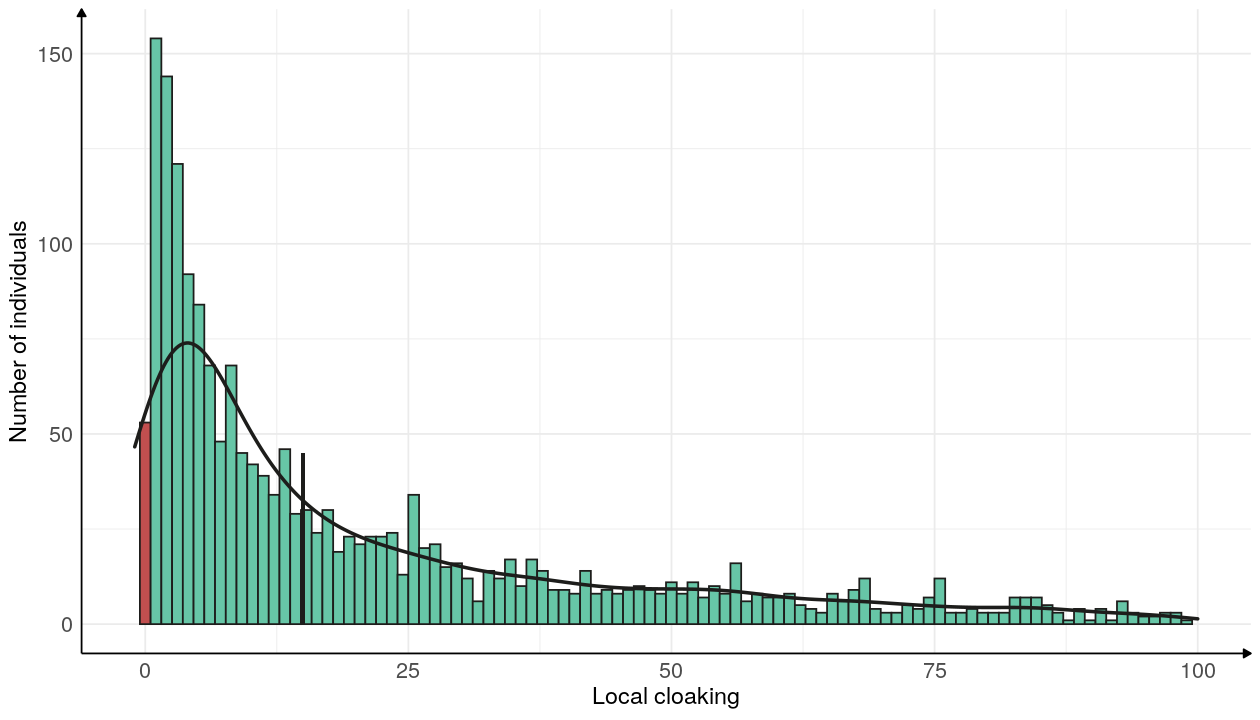

In [129]:
save = FALSE
options(repr.plot.width = 10.5, repr.plot.height = 6)

color_vector = c(rep("#c14f4f", 2), rep(colors["avatar", "color"], 98))

if (save) {
    tiff(paste0(file_results, "aids_local_cloaking.tiff"), width = 18, height = 14, 
        units = "cm", res = 300)
}


ggplot(df_local_cloaking, aes(hit_counts.1)) + 
    # add histogram
    geom_histogram(bins = 100, fill = color_vector, color = "#1D1D1B") + 
    #  add density
    geom_density(aes(y = ..count..), lwd = 1, color = "#1D1D1B") + 
    # add median
    geom_segment(aes(x = median(hit_counts.1), 
                     y = 0, 
                     xend = median(hit_counts.1), yend = 45), 
                 color = "#1D1D1B", size = 1) +
    # theme, axis, leged ...
    theme_minimal() + 
    xlab("Local cloaking") + ylab("Number of individuals") + 
    theme(axis.title = element_text(size = 14, family = "Helvetica"), 
          axis.text = element_text(size = 13, family = "Helvetica"), 
          axis.line = element_line(colour = "black", size = 0.5, 
          linetype = "solid", arrow = arrow(type = "closed", length = unit(5, "pt")))) + 
    xlim( c(-1, 100))  




if (save) {
    dev.off()
}

###  Zero cloaking over 25 avatarizations


Here, we had performe 25 diffferent avatarizations with same parameters **(`k = 20, nf = 5`)**.  
We then look at the number of time, each individual generates an avatar with a local cloaking at 0.

We print it distribution,the number of individuas according the number of zero local cloaking.


In [132]:
avatar_tot = read.csv('../../datasets/aids_avatarized_25time_k20_nf_5.csv')
avatar_tot[categorical] = lapply(avatar_tot[categorical], factor)
data[categorical] = lapply(data[categorical], factor)
pr = py$Projection()
coord_original = pr$fit_transform(data, nf = 5L)[[1]]


In [134]:
%%capture

df_local_cloaking_k2 <- data.frame(row.names = 1:nrow(data))
for (k in unique(avatar_tot$iter)){
    
    avatar <- avatar_tot[avatar_tot$iter == k,]
    
    avatar_imp <- complete(mice(avatar,m=1,maxit=50,seed=500, printFlag = FALSE),1)
    avatar$cd496 <- avatar_imp$cd496
    
    coord_avatar = pr$transform(avatar[,1:(ncol(avatar) - 1)])
    distances = py$record_to_avatar_distance(coord_original, coord_avatar)
    
    local_cloaking <- py$local_cloaking(coord_original, coord_avatar, distances)
    df_local_cloaking_k2[paste0("local_cloaking_", k, "_", 20)] <- local_cloaking$hit_counts[,1]
}

   

In [142]:
df_localCloaking_plot = df_local_cloaking_k2[, ]
df_localCloaking_plot[df_localCloaking_plot >= 5] <- 5
df_localCloaking_plot <- df_localCloaking_plot %>% mutate_if(is.character, as.factor)
df_localCloaking_plot = data.frame(df_localCloaking_plot)

rownames(df_localCloaking_plot) <- NULL
df_localCloaking_plot["names"] = as.numeric(rownames(df_localCloaking_plot))

# pivot longer the dataframe
df_melt_LC <- melt(df_localCloaking_plot, c("names"))

In [143]:
# subset only locals cloaking at 0 
df_melt_LC_0 = df_melt_LC[df_melt_LC["value"] == "0", ]

# group by individual id
df_groupby = df_melt_LC_0 %>% group_by(names, .drop = TRUE) %>% summarise(count = as.factor(n()))
df_groupby$count <- ordered(df_groupby$count, levels = c("1", "2", "3", "4", "5"))

In [144]:
# add 0 for indviduals that never get a 0 local cloaking
df_full = data.frame(names = c(1:2139))
df_full = merge(x = df_full, y = df_groupby, by = "names", all = TRUE)
df_full$count = as.numeric(df_full$count)
df_full$count[is.na(df_full$count)] <- 0
df_full$count = as.factor(df_full$count)



### Plot figure 

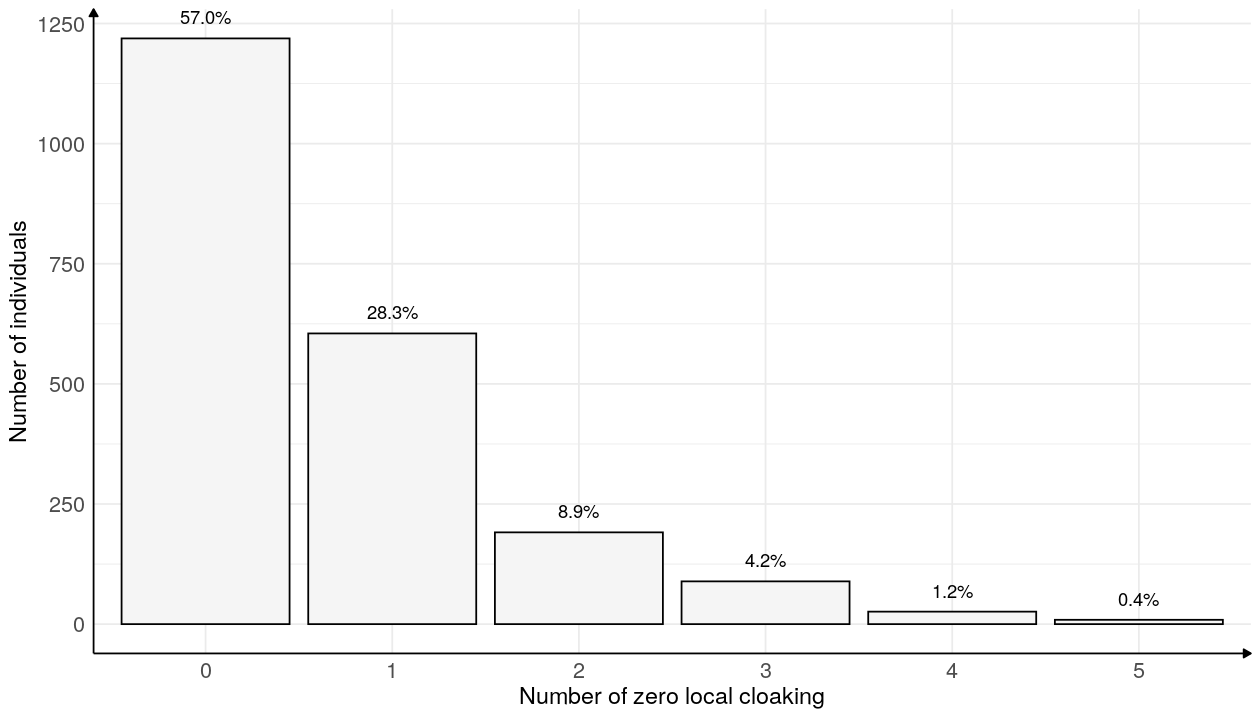

In [145]:
save = FALSE

palette2 = rep(colors["original", "color"], 6)

if (save) {
    tiff(paste0(file_results, "aids_zeroCloaking_percentage.tiff"), res = 600, width = 18, 
        height = 14, units = "cm")
}


ggplot(df_full, aes(x = count, fill = count)) + geom_bar(colour = "black", show.legend = FALSE) + 
    geom_text(aes(label = sprintf("%.1f%%", round(after_stat(count/sum(count) * 100), 
        2))), stat = "count", vjust = -1) + ylab("Number of individuals") + xlab("Number of zero local cloaking") + 
    scale_fill_manual(values = palette2) + theme_minimal() + theme(axis.title = element_text(size = 14, 
    family = "Helvetica"), axis.text = element_text(size = 13, family = "Helvetica"), 
    axis.line = element_line(colour = "black", size = 0.5, linetype = "solid", arrow = arrow(type = "closed", 
        length = unit(5, "pt"))))
if (save) {
    dev.off()
}

## P(X=0)

We also compute the probability of getting `c(1, 2, 3, 4, 5 and more)` as local cloaking

In [146]:
P_X1_list = c()
for (output in sort(unique(df_melt_LC$value))) {
    proba_X = length(df_melt_LC[(df_melt_LC$value == output), "names"])/dim(df_melt_LC)[1]
    P_X1_list = c(P_X1_list, proba_X)
}
proba = data.frame(c(0:5), P_X1_list)
colnames(proba) = c("X", "Proba")
proba

X,Proba
0,0.02726508
1,0.09782141
2,0.06799439
3,0.05451145
4,0.04314165
5,0.70926601


## P(X2 = x | X1 = y) 

We look at the conditionnal probability of getting a zero local cloaking knowing that we get 0 at a previous local cloaking.

In [147]:
tab = df <- data.frame(matrix(ncol = 6, nrow = 6))
colnames(tab) <- c(0, 1, 2, 3, 4, 5)
rownames(tab) <- c(0, 1, 2, 3, 4, 5)

In [148]:
for (X1 in c(0, 1, 2, 3, 4, 5)) {
    for (X2 in c(0, 1, 2, 3, 4, 5)) {
        
        inter_list = c()
        X1_list = c()
        i_list = unique(df_melt_LC$variable)
        j_list = unique(df_melt_LC$variable)
        
        for (i in i_list) {
            
            j_list = j_list[j_list != i]
            
            names_X1 = df_melt_LC[(df_melt_LC$value == X1) & (df_melt_LC$variable == 
                i), "names"]
            X1_list = c(X1_list, length(names_X1))
            
            for (j in j_list) {
                
                names_X2 = df_melt_LC[(df_melt_LC$value == X2) & (df_melt_LC$variable == 
                  j), "names"]
                length_inter = length(intersect(names_X1, names_X2))
                inter_list = c(inter_list, length_inter)
                
            }
        }
        if (X2 == 5) {
            print(mean(X1_list))
            print(mean(inter_list))
        }
        
        P_X1 = mean(X1_list)/dim(df_melt_LC[(df_melt_LC$variable == i), ])[1]
        P_X2_inter_X1 = mean(inter_list)/dim(df_melt_LC[(df_melt_LC$variable == i), 
            ])[1]
        P_X2_sachant_X1 = P_X2_inter_X1/P_X1
        tab[X1 + 1, X2 + 1] = P_X2_sachant_X1
        
    }
}

[1] 58.32
[1] 33.62667
[1] 209.24
[1] 119.3667
[1] 145.44
[1] 90.46667
[1] 116.6
[1] 73.26333
[1] 92.28
[1] 60.57333
[1] 1517.12
[1] 1137.47


In [149]:
rowSums(tab)
round(tab, 4)

0         1         2         3         4         5 
1.0194330 0.9907761 1.0107948 0.9768725 0.9953403 1.0015512

,0,1,2,3,4,5
0,0.0497,0.1695,0.1008,0.0701,0.0528,0.5766
1,0.0465,0.1618,0.0944,0.0678,0.0498,0.5705
2,0.0395,0.1402,0.0899,0.0682,0.0509,0.6220
3,0.0316,0.1179,0.0805,0.0670,0.0516,0.6283
4,0.0290,0.1130,0.0797,0.0651,0.0522,0.6564
5,0.0214,0.0810,0.0583,0.0509,0.0402,0.7498


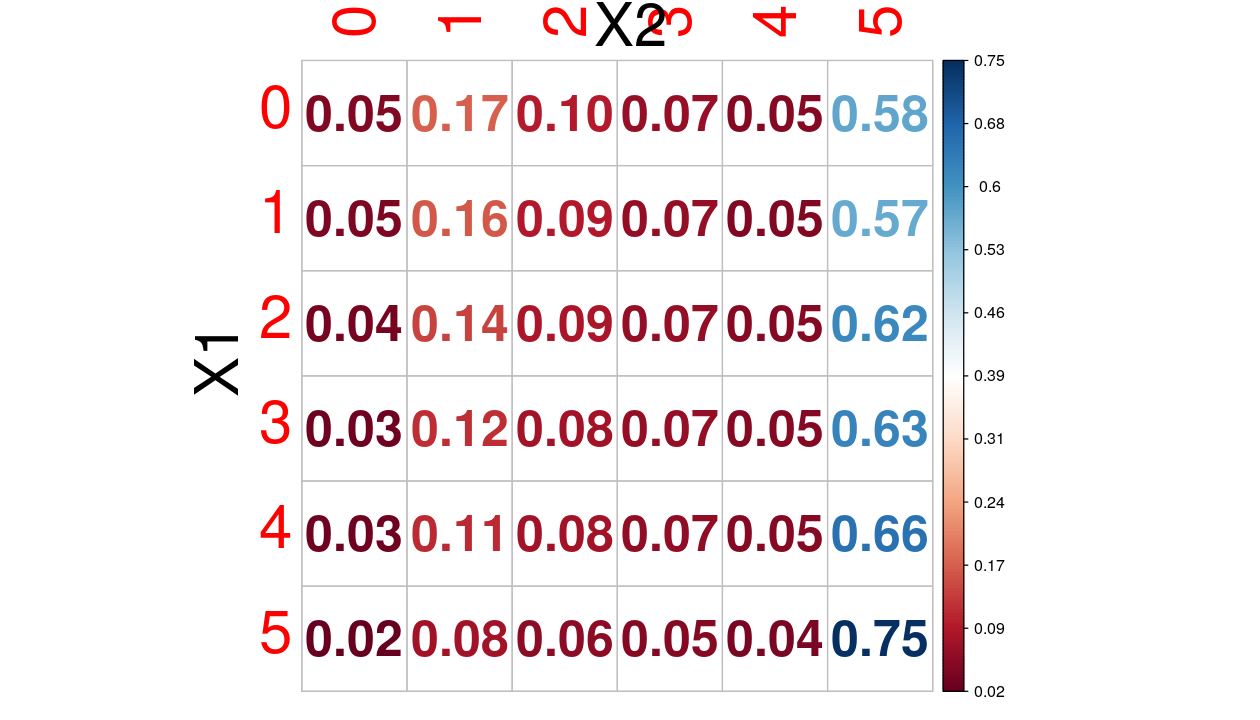

In [150]:
corrplot(as.matrix(tab), method = "number", is.corr = FALSE, number.cex = 2.5, tl.cex = 3)
mtext(text = "X1", side = 2, line = -6, las = 3, cex = 3)
mtext(text = "X2", side = 3, line = 2, las = 1, cex = 3)